In [1]:
import pandas as pd
from numpy import *
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as pl
from scipy.optimize import least_squares
from datetime import date, timedelta
import random
import math

## Import de dados

In [2]:
# Dados começam 01/01/2022
# Vacinação começa 19/01/2022
# fillna(0) substitui todos os valores sem input por 0
Dados= pd.read_csv('../dados_usados/Dados_novos_BAHIA.csv')
vacinados_dados = Dados['Vacinados'].fillna(0)
mortos_dados = Dados['Mortos'].fillna(0)
casos_dados = Dados['Casos acumulados']
datas = Dados["datetime"].fillna(0)

## Adiantamento da vacinação para 1 de janeiro de 2021

In [3]:
vacinados_dados_adiantados = vacinados_dados[19:]
vacinados_dados_adiantados = vacinados_dados_adiantados.tolist()
for item in range(19):
    vacinados_dados_adiantados.append(0)

vacinados_dados_aux =  copy(vacinados_dados_adiantados)
# Diffs menores que 0 serão substituidos pela repetição do valor anterior, tornando todo valor igual ou maior que o anterior
for i in range(1,len(vacinados_dados_aux)):
    diff = vacinados_dados_aux[i] - vacinados_dados_aux[i-1]
    if diff < 0:
        vacinados_dados_aux[i-1] = vacinados_dados_aux[i]

novos_vacinados_adiantados =  np.diff(vacinados_dados_aux)
novos_vacinados_adiantados = novos_vacinados_adiantados.tolist()
novos_vacinados_adiantados.insert(0, 0)

print(len(novos_vacinados_adiantados))

334


## Vacinação sem adiantamento

In [4]:
vacinados_dados_aux =  copy(vacinados_dados)
# Diffs menores que 0 serão substituidos pela repetição do valor anterior, tornando todo valor igual ou maior que o anterior
for i in range(1,len(vacinados_dados_aux)):
    diff = vacinados_dados_aux[i] - vacinados_dados_aux[i-1]
    if diff < 0:
        vacinados_dados_aux[i-1] = vacinados_dados_aux[i]

novos_vacinados =  np.diff(vacinados_dados_aux)
novos_vacinados = novos_vacinados.tolist()
novos_vacinados.insert(0, 0)
print(len(novos_vacinados))

334


<h4>Condições iniciais simulação</h4>

In [5]:
vacinados_dados_adiantados_inicial = vacinados_dados[42:]
vacinados_dados_adiantados_inicial = vacinados_dados_adiantados_inicial.tolist()
print(vacinados_dados_adiantados_inicial[0])
for item in range(43):
    vacinados_dados_adiantados_inicial.append(0)

vacinados_dados_aux_inicial =  copy(vacinados_dados_adiantados_inicial)
# Diffs menores que 0 serão substituidos pela repetição do valor anterior, tornando todo valor igual ou maior que o anterior
for i in range(1,len(vacinados_dados_aux_inicial)):
    diff = vacinados_dados_aux_inicial[i] - vacinados_dados_aux_inicial[i-1]
    if diff < 0:
        vacinados_dados_aux_inicial[i-1] = vacinados_dados_aux_inicial[i]

novos_vacinados_adiantados_inicial =  np.diff(vacinados_dados_aux_inicial)
novos_vacinados_adiantados_inicial = novos_vacinados_adiantados_inicial.tolist()
novos_vacinados_adiantados_inicial.insert(0, 0)

print(len(novos_vacinados_adiantados_inicial))

366446.0
335


# Parametros

In [6]:
# Ultima revisão: 05/01/2023
k = 1/4
gamma_a = 1/3.5
gamma_s = 1/4
gamma_h = 0.18
gamma_u = 0.13
mi_u = 0.4
qsi = 0.53 
h = 0.06
h_v = 0.012
mi_h = 0.15
ome_h = 0.14
ome_u = 0.29
delta = 0.31
p = 0.2

# Parametros da vacina    
delta_av = 0.31
delta_sv = 0.31
phi_e = 0.7
k_v=1/3
p_v = 0.1
gamma_av = 1/3.5
gamma_sv = 1/4
gamma_vu=0.26
qsi_v = 0.99
eps=0.7 # eficacia da vacina
mi_vh=0.03
mi_vu=0.08
gamma_vh=0.36


# Modelo

In [7]:
def SEIIHURD(y,t, args):

    beta0, beta1, beta2,beta3, t1, t2,t3, vacinacao_adiantada = args

    if t<t1:
        beta=beta0    
    elif (t>=t1):
        beta=beta1
    elif (t>=t2):
        beta=beta2
    elif t>=t3:
        beta=beta3

    beta_v = beta/2
    
    if vacinacao_adiantada == 'ANO':
        tau = novos_vacinados_adiantados[int(t)]
    elif vacinacao_adiantada == 'VACINACAO':
        tau = novos_vacinados_adiantados_inicial[int(t)]
    else:
        tau = novos_vacinados[int(t)]


    N=14873064
    
    psi= 0.5  #Psif[int(t)]
    S=y[0]
    E=y[1]
    V=y[2]
    Sv=y[3]
    Ev=y[4]
    Ia=y[5]
    Is=y[6]
    Iav=y[7]
    Isv=y[8]
    H=y[9]
    Hv=y[10]
    U=y[11]
    Uv=y[12]
    R=y[13]
    Rv=y[14]
    D=y[15]
    Nw=y[16]
    NwV=y[17]

    dSdt = (-(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - tau/N
    dEdt = ((1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k*E
    dVdt = tau/N - phi_e*V - ((1-psi)*beta*V*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv))
    dSvdt =  phi_e*(1-eps)*V - ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) #- phi_e*eps*Sv
    dEvdt = ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k_v*Ev
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv   
    dHdt = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H   
    dHvdt = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vh*Hv    
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U
    dUvdt = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_vh*Hv - gamma_u*Uv
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H
    dRvdt = gamma_av*Iav + (1-h_v)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv) + phi_e*eps*V
    dDdt = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_u)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv)
    dNwdt = p*k*E + p_v*k_v*Ev
    dNwVdt = tau/N
        
    return [dSdt, dEdt, dVdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, 
            dRvdt, dDdt, dNwdt, dNwVdt]


# Condições iniciais

In [8]:
condicoes_iniciais = [
    0.8002151436282163 ,
    0.0023662791892471815,
    0,
    0,
    0,
    0.0015491725384642486,
    0.0004385474858925033,
    0,
    0,
    3.0058880370174367e-05,
    0.0,
    2.5542546092586197e-05,
    0.0,
    0.15650499264821266,
    0,
    9159/14873064,
    0.03581418879497971,
    0
]

In [9]:
condicoes_iniciais2 = [
    0.8002151436282163 ,
    0.0023662791892471815,
    vacinados_dados_adiantados_inicial[0]/14873064,
    0,
    0,
    0.0015491725384642486,
    0.0004385474858925033,
    0,
    0,
    3.0058880370174367e-05,
    0.0,
    2.5542546092586197e-05,
    0.0,
    0.15650499264821266,
    0,
    9159/14873064,
    0.03581418879497971,
    0
]

# Integração numérica 

In [10]:
ts0 =  arange(len(novos_vacinados))

# Betas e tempos encontrados no último fitting usando os dados da vacina
parode = [  1.90221545,   3.76585085,   2.14629225,   3.27760444,
       126.48480189, 172.97799643, 288.57269974,'ANO']

resultados_adiantado = odeint(SEIIHURD, condicoes_iniciais, ts0, args=(parode,), mxstep=1000000)

parode2 = [  1.90221545,   3.76585085,   2.14629225,   3.27760444,
       126.48480189, 172.97799643, 288.57269974, 'none']

resultados_normais = odeint(SEIIHURD, condicoes_iniciais, ts0, args=(parode2,), mxstep=1000000)

parode3 = [  1.90221545,   3.76585085,   2.14629225,   3.27760444,
       126.48480189, 172.97799643, 288.57269974, 'VACINACAO']

resultados_muito_adiantados = odeint(SEIIHURD, condicoes_iniciais2, ts0, args=(parode3,), mxstep=1000000)

# Plot resultados

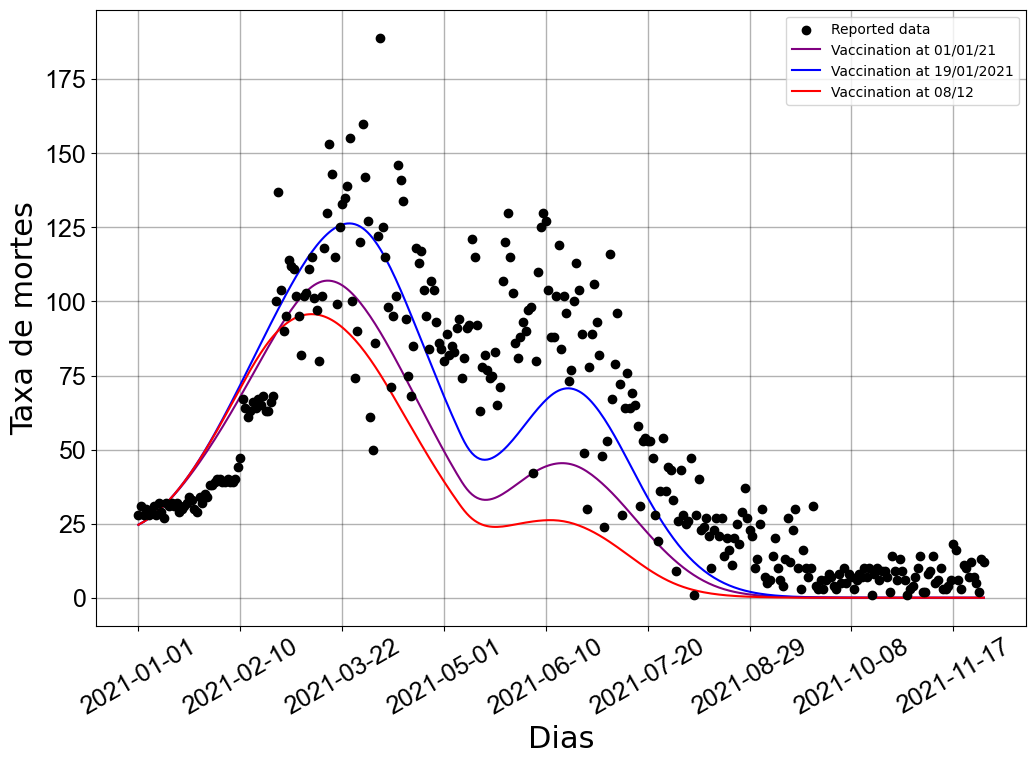

In [11]:
N = 14873064

mortes_resultados_adiantado = resultados_adiantado[:,-3] #mortes acumulados
mortes_resultados_normal = resultados_normais[:,-3] #mortes acumulados
mortes_resultado_muito_adiantado = resultados_muito_adiantados[:,-3]

#Criando plot
fig, ax = pl.subplots(figsize=(12,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)

# Taxa de mortos - dados
taxa_mortos_dados = np.diff(mortos_dados)
ax.scatter(datas[:len(taxa_mortos_dados)], taxa_mortos_dados, color='black', zorder=3, label='Reported data')

# Taxa de mortos - modelo
taxa_mortos_modelo_adiantado = np.diff(N*mortes_resultados_adiantado)
#Plot the fitted function as a line.
ax.plot(datas[:len(taxa_mortos_modelo_adiantado)], taxa_mortos_modelo_adiantado, color='purple',label='Vaccination at 01/01/21')

# Taxa de mortos - modelo
taxa_mortos_modelo_normal = np.diff(N*mortes_resultados_normal)
#Plot the fitted function as a line.
ax.plot(datas[:len(taxa_mortos_modelo_normal)], taxa_mortos_modelo_normal, color='blue',label='Vaccination at 19/01/2021')

# Taxa de mortos - modelo
taxa_mortos_modelo_muito_adiantado = np.diff(N*mortes_resultado_muito_adiantado)
#Plot the fitted function as a line.
ax.plot(datas[:len(taxa_mortos_modelo_muito_adiantado)], taxa_mortos_modelo_muito_adiantado, color='red',label='Vaccination at 08/12')

ax.autoscale()

#Set the labels
ax.set_ylabel('Taxa de mortes',fontsize=22)
ax.set_xlabel('Dias', fontsize=22)
#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(pl.MaxNLocator(10))
#Rotating the dates for better visualization
pl.setp(ax.get_xticklabels(), rotation=30)


#Setting the font of the numbers on the axixis as ARIAL 
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")  
pl.legend()
#Show Graph       
pl.show()


In [ ]:
df = pd.DataFrame(mortes_resultados_adiantado)
df.to_csv('Antecipacao/mortes_resultados_adiantado.csv', index=False)
df = pd.DataFrame(mortes_resultados_normal)
df.to_csv('Antecipacao/mortes_resultados_normal.csv', index=False)
df = pd.DataFrame(mortes_resultado_muito_adiantado)
df.to_csv('Antecipacao/mortes_resultado_muito_adiantado.csv', index=False)

## Casos

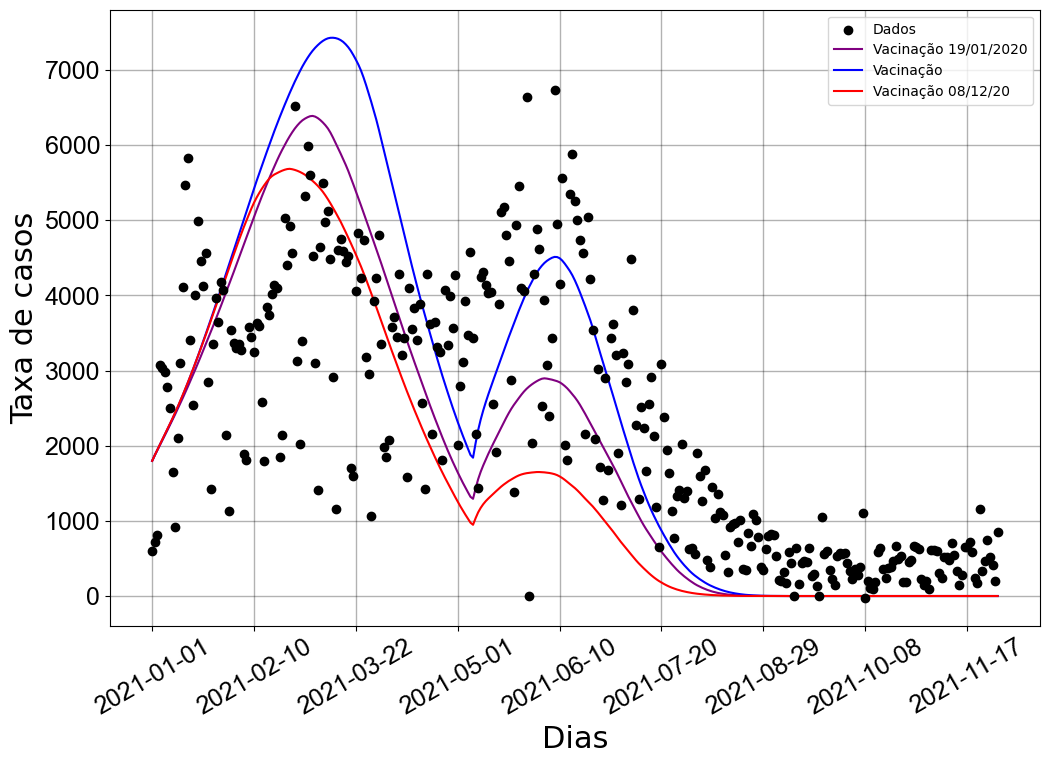

In [12]:
N = 14873064

casos_resultados_adiantados = resultados_adiantado[:,-2] #mortes acumulados
casos_resultados_normais = resultados_normais[:,-2] #mortes acumulados
casos_resultados_muito_adiantados = resultados_muito_adiantados[:,-2] #mortes acumulados

#Criando plot
fig, ax = pl.subplots(figsize=(12,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)

# Taxa de mortos - dados
taxa_casos_dados = np.diff(casos_dados)
ax.scatter(datas[:len(taxa_casos_dados)], taxa_casos_dados, color='black', zorder=3, label='Dados')

# Taxa de mortos - modelo
taxa_casos_adiantados = np.diff(N*casos_resultados_adiantados)
#Plot the fitted function as a line.
ax.plot(datas[:len(taxa_casos_adiantados)], taxa_casos_adiantados, color='purple',label='Vacinação 19/01/2020')

# Taxa de mortos - modelo
taxa_casos_modelo_normal = np.diff(N*casos_resultados_normais)
#Plot the fitted function as a line.
ax.plot(datas[:len(taxa_casos_modelo_normal)], taxa_casos_modelo_normal, color='blue',label='Vacinação')

# Taxa de mortos - modelo
taxa_casos_modelo_muito_adiantado = np.diff(N*casos_resultados_muito_adiantados)
#Plot the fitted function as a line.
ax.plot(datas[:len(taxa_casos_modelo_muito_adiantado)], taxa_casos_modelo_muito_adiantado, color='red',label='Vacinação 08/12/20')


ax.autoscale()

#Set the labels
ax.set_ylabel('Taxa de casos',fontsize=22)
ax.set_xlabel('Dias', fontsize=22)
#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(pl.MaxNLocator(10))
#Rotating the dates for better visualization
pl.setp(ax.get_xticklabels(), rotation=30)


#Setting the font of the numbers on the axixis as ARIAL 
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")  
pl.legend()
#Show Graph       
pl.show()
